In [13]:
import lightning as L
import torch.nn.functional as F
import timm
import torch
from torcheval.metrics import MulticlassF1Score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from lightning.pytorch.callbacks import ModelCheckpoint
torch.set_float32_matmul_precision("medium") # Take advantage of the tensor cores on the RTX GPU.

In [14]:
#A manual seed used for reproducibility throughout this notebook.
MANUAL_SEED = 7
# The number of epochs used for all training done in this notebook.
EPOCHS = 10
# The batch size used for all training done in this notebook.
BATCH_SIZE = 4096 # As much as the GPU can handle for the biggest model.
# The learning rate used for all training done in this notebook.
LEARNINIG_RATE = 1e-3
# The number of classes in the CIFAR10 dataset.
NUM_CLASSES = 10

In [15]:
# Timm is a library for loading pre-trained (or not) models. 
timm.list_models() #Lists the IDs of the available models.

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [16]:
# Gotta extract the model code into nn.module
# then build a lightning module to handle the training pipeline
# Then throw away this lightning module and create a new one for distillation
# Load the model using .load_state_dict() like shown here : https://github.com/Lightning-AI/pytorch-lightning/issues/20053#issuecomment-2215485554

In [17]:
class TeacherResNet50(torch.nn.Module):
    def __init__(self, num_classes : int, pretrained: bool = True) -> None:
        """An implementation of a fine-tunable Resnet50 pretrained (or not) model.
        The final classification layer is replaced with a new one that predicts the number of classes defined by 'num_classes'.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained: A boolean value indicating whether to load the pre-trained weights of the model. Defaults to true.
        """
        super().__init__()
        self.resnet50 = timm.create_model('resnet50', pretrained=pretrained)
        #Replace the final classification layer of the model for fine-tuning purposes.
        self.resnet50.fc = torch.nn.Linear(
            in_features=self.resnet50.fc.in_features,
            out_features=num_classes
        )
    
    def forward(self, x):
        return self.resnet50(x)

In [18]:
class StudentResNet18(torch.nn.Module):
    def __init__(self, num_classes : int, pretrained: bool = True) -> None:
        """An implementation of a fine-tunable Resnet18 pretrained (or not) model.
        The final classification layer is replaced with a new one that predicts the number of classes defined by 'num_classes'.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained: A boolean value indicating whether to load the pre-trained weights of the model. Defaults to true.
        """
        super().__init__()
        self.resnet18 = timm.create_model('resnet18', pretrained=pretrained)
        #Replace the final classification layer of the model for fine-tuning purposes.
        self.resnet18.fc = torch.nn.Linear(
            in_features=self.resnet18.fc.in_features,
            out_features=num_classes
        )

    def forward(self, x):
        return self.resnet18(x)

In [19]:
class TrainingTeacherResNet50(L.LightningModule):
    def __init__(self, num_classes : int, pretrained: bool = True, lr : float = 1e-4) -> None:
        """A pytorch lightning implementation of the Resnet50 fine-tuning process.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained: A boolean value indicating whether to load the pre-trained weights of the model. Defaults to true.
            lr: The learning rate used during training. Defaults to 1e-4.
        """
        super().__init__()
        self.resnet50 = TeacherResNet50(num_classes=num_classes,
                                        pretrained=pretrained)
        self.lr = lr
        self.f1_metric = MulticlassF1Score(num_classes=num_classes)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.resnet50(input_tensor)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        input_batch, target_batch = batch
        logits = self(input_batch).squeeze()
        loss = torch.nn.functional.cross_entropy(logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(logits, target_batch)
        train_f1_score = self.f1_metric.compute()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", train_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        input_batch, target_batch = batch
        logits = self(input_batch).squeeze()
        loss = torch.nn.functional.cross_entropy(logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(logits, target_batch)
        validation_f1_score = self.f1_metric.compute()
        self.log("validation_loss", loss, on_epoch=True, prog_bar=True)
        self.log("validation_f1_score", validation_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        input_batch, target_batch = batch
        logits = self(input_batch).squeeze()
        loss = torch.nn.functional.cross_entropy(logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(logits, target_batch)
        test_f1_score = self.f1_metric.compute()
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_f1_score", test_f1_score, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [20]:
class TrainingStudentResNet18(L.LightningModule):
    def __init__(self, num_classes : int, pretrained: bool = True, lr : float = 1e-4) -> None:
        """A pytorch lightning implementation of the Resnet18 pretrained model.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained: A boolean value indicating whether to load the pre-trained weights of the model. Defaults to true.
            lr: The learning rate used during training. Defaults to 1e-4.
        """
        super().__init__()
        self.resnet18 = StudentResNet18(num_classes=num_classes,
                                        pretrained=pretrained)
        self.lr = lr
        self.f1_metric = MulticlassF1Score(num_classes=num_classes)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.resnet18(input_tensor)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        input_batch, target_batch = batch
        logits = self(input_batch).squeeze()
        loss = torch.nn.functional.cross_entropy(logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(logits, target_batch)
        train_f1_score = self.f1_metric.compute()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", train_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        input_batch, target_batch = batch
        logits = self(input_batch).squeeze()
        loss = torch.nn.functional.cross_entropy(logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(logits, target_batch)
        validation_f1_score = self.f1_metric.compute()
        self.log("validation_loss", loss, on_epoch=True, prog_bar=True)
        self.log("validation_f1_score", validation_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        input_batch, target_batch = batch
        logits = self(input_batch).squeeze()
        loss = torch.nn.functional.cross_entropy(logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(logits, target_batch)
        test_f1_score = self.f1_metric.compute()
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_f1_score", test_f1_score, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

## Load the Cifar10 dataset

In [21]:
transform = transforms.Compose([
    #transforms.Resize((128, 128)), #Making images bigger causes extremely slow training, even with small batches. Removed for now.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the training and test datasets.
train_dataset = datasets.CIFAR10(root="./CIFAR10", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)

# Create a validation set from the training set (80% train, 20% validation).
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
#Use a manual seed for reproducibility.
generator = torch.Generator().manual_seed(MANUAL_SEED)
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size], generator=generator)

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


# Fine-tune the teacher model on the CIFAR10 dataset

In [22]:
# Instantiate the pre-trained teacher model with 10 classes for the classifier.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer.
teacherResnet50 = TrainingTeacherResNet50(num_classes=NUM_CLASSES,
                                  pretrained=True,
                                  lr=LEARNINIG_RATE)

In [23]:
# Only save to disk the best performing version of the model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/pretrained_teacher_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [24]:
trainer.fit(model=teacherResnet50, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | resnet50 | TeacherResNet50 | 23.5 M | train
-----------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
218       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:48<00:00,  0.21it/s, v_num=4, train_loss_step=1.920, train_f1_score_step=0.305, validation_loss=1.650, validation_f1_score=0.310, train_loss_epoch=2.170, train_f1_score_epoch=0.216]

Epoch 0, global step 10: 'validation_f1_score' reached 0.31045 (best 0.31045), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:47<00:00,  0.21it/s, v_num=4, train_loss_step=1.220, train_f1_score_step=0.391, validation_loss=1.620, validation_f1_score=0.394, train_loss_epoch=1.510, train_f1_score_epoch=0.356]

Epoch 1, global step 20: 'validation_f1_score' reached 0.39362 (best 0.39362), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:47<00:00,  0.21it/s, v_num=4, train_loss_step=0.827, train_f1_score_step=0.463, validation_loss=1.020, validation_f1_score=0.466, train_loss_epoch=0.961, train_f1_score_epoch=0.431]

Epoch 2, global step 30: 'validation_f1_score' reached 0.46642 (best 0.46642), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:46<00:00,  0.22it/s, v_num=4, train_loss_step=0.605, train_f1_score_step=0.527, validation_loss=0.813, validation_f1_score=0.529, train_loss_epoch=0.650, train_f1_score_epoch=0.499]

Epoch 3, global step 40: 'validation_f1_score' reached 0.52929 (best 0.52929), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:50<00:00,  0.20it/s, v_num=4, train_loss_step=0.394, train_f1_score_step=0.575, validation_loss=0.776, validation_f1_score=0.577, train_loss_epoch=0.435, train_f1_score_epoch=0.554]

Epoch 4, global step 50: 'validation_f1_score' reached 0.57677 (best 0.57677), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:58<00:00,  0.17it/s, v_num=4, train_loss_step=0.253, train_f1_score_step=0.612, validation_loss=0.780, validation_f1_score=0.613, train_loss_epoch=0.279, train_f1_score_epoch=0.596]

Epoch 5, global step 60: 'validation_f1_score' reached 0.61345 (best 0.61345), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:50<00:00,  0.20it/s, v_num=4, train_loss_step=0.162, train_f1_score_step=0.641, validation_loss=0.848, validation_f1_score=0.642, train_loss_epoch=0.170, train_f1_score_epoch=0.629]

Epoch 6, global step 70: 'validation_f1_score' reached 0.64200 (best 0.64200), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:56<00:00,  0.18it/s, v_num=4, train_loss_step=0.0914, train_f1_score_step=0.664, validation_loss=0.897, validation_f1_score=0.665, train_loss_epoch=0.100, train_f1_score_epoch=0.654]

Epoch 7, global step 80: 'validation_f1_score' reached 0.66464 (best 0.66464), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:47<00:00,  0.21it/s, v_num=4, train_loss_step=0.0509, train_f1_score_step=0.683, validation_loss=0.983, validation_f1_score=0.683, train_loss_epoch=0.0596, train_f1_score_epoch=0.674]

Epoch 8, global step 90: 'validation_f1_score' reached 0.68303 (best 0.68303), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:48<00:00,  0.21it/s, v_num=4, train_loss_step=0.0374, train_f1_score_step=0.697, validation_loss=1.040, validation_f1_score=0.698, train_loss_epoch=0.0393, train_f1_score_epoch=0.691]

Epoch 9, global step 100: 'validation_f1_score' reached 0.69775 (best 0.69775), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_teacher_training\\best.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:49<00:00,  0.20it/s, v_num=4, train_loss_step=0.0374, train_f1_score_step=0.697, validation_loss=1.040, validation_f1_score=0.698, train_loss_epoch=0.0393, train_f1_score_epoch=0.691]


In [19]:
# Test the teacher model.
trainer.test(model=teacherResnet50, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score         0.7022854685783386
        test_loss           1.0286998748779297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0286998748779297, 'test_f1_score': 0.7022854685783386}]

Loss graph :

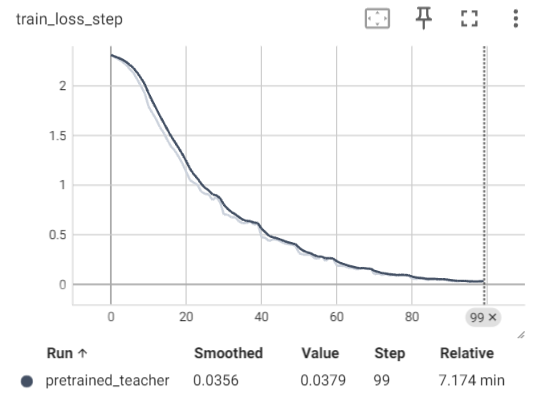

Validation F1 score graph :

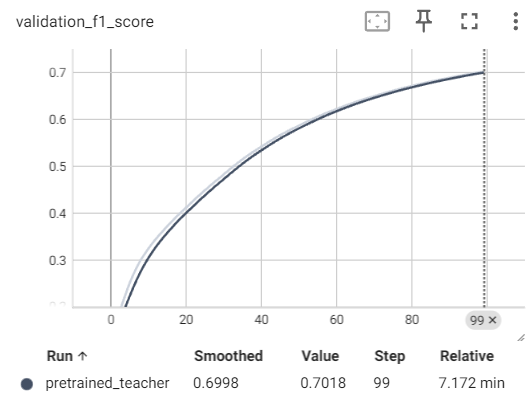

In [20]:
# The number of parameters for the teacher Resnet50 (extracted from training output).
#   | Name     | Type   | Params | Mode 
# --------------------------------------------
# 0 | resnet50 | ResNet | 23.5 M | train
# --------------------------------------------
# 23.5 M    Trainable params
# 0         Non-trainable params
# 23.5 M    Total params
# 94.114    Total estimated model params size (MB)
# 217       Modules in train mode
# 0         Modules in eval mode

# Strategy 1 : Knowledge distillation using a pre-trained student

## Fine-tune the pre-trained student network on CIFAR10

In [21]:
# Instantiate the pre-trained student model with 10 classes for the classifier.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer.
studentResnet18 = TrainingStudentResNet18(num_classes=10,
                                  pretrained=True,
                                  lr=LEARNINIG_RATE)

In [22]:
# Only save to disk the best performing version of the model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/pretrained_student_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [23]:
trainer.fit(model=studentResnet18, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | resnet18 | StudentResNet18 | 11.2 M | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
95        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 10/10 [00:22<00:00,  0.45it/s, v_num=1, train_loss_step=1.940, train_f1_score_step=0.231, validation_loss=1.820, validation_f1_score=0.239, train_loss_epoch=2.170, train_f1_score_epoch=0.153]

Epoch 0, global step 10: 'validation_f1_score' reached 0.23864 (best 0.23864), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:23<00:00,  0.42it/s, v_num=1, train_loss_step=1.360, train_f1_score_step=0.348, validation_loss=1.510, validation_f1_score=0.352, train_loss_epoch=1.600, train_f1_score_epoch=0.302]

Epoch 1, global step 20: 'validation_f1_score' reached 0.35198 (best 0.35198), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:23<00:00,  0.42it/s, v_num=1, train_loss_step=1.030, train_f1_score_step=0.422, validation_loss=1.240, validation_f1_score=0.424, train_loss_epoch=1.120, train_f1_score_epoch=0.390]

Epoch 2, global step 30: 'validation_f1_score' reached 0.42441 (best 0.42441), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:21<00:00,  0.47it/s, v_num=1, train_loss_step=0.797, train_f1_score_step=0.481, validation_loss=0.959, validation_f1_score=0.483, train_loss_epoch=0.852, train_f1_score_epoch=0.455]

Epoch 3, global step 40: 'validation_f1_score' reached 0.48326 (best 0.48326), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:21<00:00,  0.46it/s, v_num=1, train_loss_step=0.645, train_f1_score_step=0.528, validation_loss=0.842, validation_f1_score=0.529, train_loss_epoch=0.678, train_f1_score_epoch=0.507]

Epoch 4, global step 50: 'validation_f1_score' reached 0.52933 (best 0.52933), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:19<00:00,  0.50it/s, v_num=1, train_loss_step=0.518, train_f1_score_step=0.564, validation_loss=0.808, validation_f1_score=0.565, train_loss_epoch=0.548, train_f1_score_epoch=0.548]

Epoch 5, global step 60: 'validation_f1_score' reached 0.56510 (best 0.56510), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:18<00:00,  0.54it/s, v_num=1, train_loss_step=0.407, train_f1_score_step=0.593, validation_loss=0.793, validation_f1_score=0.594, train_loss_epoch=0.441, train_f1_score_epoch=0.580]

Epoch 6, global step 70: 'validation_f1_score' reached 0.59381 (best 0.59381), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:18<00:00,  0.54it/s, v_num=1, train_loss_step=0.351, train_f1_score_step=0.616, validation_loss=0.797, validation_f1_score=0.617, train_loss_epoch=0.346, train_f1_score_epoch=0.606]

Epoch 7, global step 80: 'validation_f1_score' reached 0.61718 (best 0.61718), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:18<00:00,  0.55it/s, v_num=1, train_loss_step=0.263, train_f1_score_step=0.636, validation_loss=0.826, validation_f1_score=0.637, train_loss_epoch=0.265, train_f1_score_epoch=0.627]

Epoch 8, global step 90: 'validation_f1_score' reached 0.63675 (best 0.63675), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:18<00:00,  0.54it/s, v_num=1, train_loss_step=0.185, train_f1_score_step=0.653, validation_loss=0.849, validation_f1_score=0.653, train_loss_epoch=0.195, train_f1_score_epoch=0.646]

Epoch 9, global step 100: 'validation_f1_score' reached 0.65338 (best 0.65338), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\pretrained_student_training\\best.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:18<00:00,  0.53it/s, v_num=1, train_loss_step=0.185, train_f1_score_step=0.653, validation_loss=0.849, validation_f1_score=0.653, train_loss_epoch=0.195, train_f1_score_epoch=0.646]


In [24]:
# Test the student model.
trainer.test(model=studentResnet18, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score         0.6541073322296143
        test_loss           0.8343192338943481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8343192338943481, 'test_f1_score': 0.6541073322296143}]

Training loss graph :

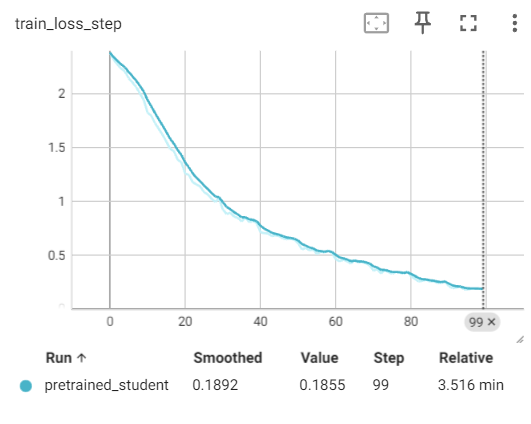

Validation f1 score graph :

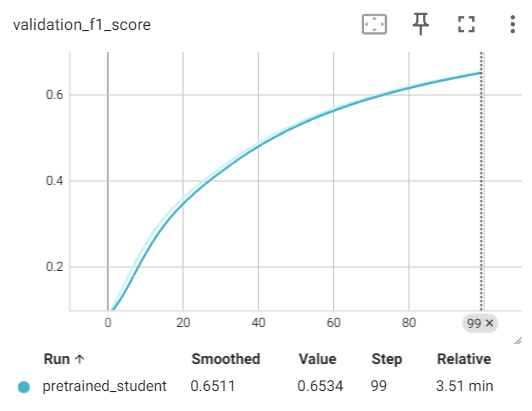

In [25]:
# The number of parameters for the student Resnet18 (extracted from training output).
#  | Name     | Type   | Params | Mode 
#--------------------------------------------
#0 | resnet18 | ResNet | 11.2 M | train
#--------------------------------------------
#11.2 M    Trainable params
#0         Non-trainable params
#11.2 M    Total params
#44.727    Total estimated model params size (MB)
#94        Modules in train mode
#0         Modules in eval mode

## Test results comparison
 
Teacher model f1 score : 70.22%

Student model f1 score : 65.41%

## Perform distillation based on scores

In [47]:
class DistilledStudentResnet18(L.LightningModule):
    def __init__(self, num_classes : int,
                 pretrained_student: bool = True,
                 lr : float = 1e-4,
                 temperature : float = 2,
                 soft_target_loss_weight : float = 0.25,
                 cross_entropy_loss_weight : float = 0.75) -> None:
        """A pytorch lightning implementation of the distillation process for the pretrained (or not) Resnet18 model.
        Implementation is inspired from https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html
        The teacher model is the fine-tuned Resnet50.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained_student: A boolean value indicating whether to load the pre-trained weights of the student model. Defaults to true.
            lr: The learning rate used during training. Defaults to 1e-4.
            temperature : Controls the smoothness of the output distributions. Larger T leads to smoother distributions, thus smaller probabilities get a larger boost. Defaults to 2.
            soft_target_loss_weight : A weight assigned to the loss calculated on the scores. Defaults to 0.25.
            cross_entropy_loss_weight : A weight assigned to the cross entropy loss calculated on the targets. Defaults to 0.75.
        """
        super().__init__()
        # Load the pre-trained (or not) student model.

        self.student_resnet18 = StudentResNet18(num_classes=NUM_CLASSES,
                                                pretrained=pretrained_student)
        # Load the fine-tuned teacher model.
        teacherResnet50 = TrainingTeacherResNet50.load_from_checkpoint("finetuned_models/pretrained_teacher_training/best.ckpt",
                                                                       num_classes=NUM_CLASSES,
                                                                       pretrained=False)
        self.teacherResnet50 = teacherResnet50.resnet50 # Extract the resnet50 model to get rid of the previous pytorch lightning training logic.
        
        self.lr = lr
        self.f1_metric = MulticlassF1Score(num_classes=num_classes)
        self.temperature = temperature
        self.soft_target_loss_weight = soft_target_loss_weight
        self.cross_entropy_loss_weight = cross_entropy_loss_weight

    def forward(self, input_tensor: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """This forward method runs the inference for both the teacher and the student model and returns their logits as a tuple (teacher_logits, student_logits)."""
        with torch.no_grad(): #Freeze teacher model weights.
            teacher_logits = self.teacherResnet50(input_tensor)
        
        student_logits = self.student_resnet18(input_tensor)
        return teacher_logits, student_logits

    def training_step(self, batch, batch_idx):
        self.teacherResnet50.eval()
        # training_step defines the train loop.
        input_batch, target_batch = batch
        teacher_logits, student_logits = self(input_batch)
        #Soften the logits using the temperature.
        soft_targets = torch.nn.functional.softmax(teacher_logits / self.temperature, dim=-1)
        soft_prob = torch.nn.functional.log_softmax(student_logits / self.temperature, dim=-1)

        soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (self.temperature**2)

        cross_entropy_loss = torch.nn.functional.cross_entropy(student_logits, target_batch)

        #Calculate the weighted sum of the two losses.
        loss = self.soft_target_loss_weight * soft_targets_loss + self.cross_entropy_loss_weight * cross_entropy_loss
        #Calculate metrics
        self.f1_metric.update(student_logits, target_batch)
        train_f1_score = self.f1_metric.compute()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", train_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        input_batch, target_batch = batch
        _, student_logits = self(input_batch)
        loss = torch.nn.functional.cross_entropy(student_logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(student_logits, target_batch)
        validation_f1_score = self.f1_metric.compute()
        self.log("validation_loss", loss, on_epoch=True, prog_bar=True)
        self.log("validation_f1_score", validation_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        input_batch, target_batch = batch
        _, student_logits= self(input_batch)
        loss = torch.nn.functional.cross_entropy(student_logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(student_logits, target_batch)
        test_f1_score = self.f1_metric.compute()
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_f1_score", test_f1_score, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [48]:
# Instantiate the distillation model.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer of the student model.
distilled_student_resnet18 = DistilledStudentResnet18(num_classes=NUM_CLASSES,
                                                      pretrained_student=True,
                                                      lr=LEARNINIG_RATE,
                                                      temperature=2,
                                                      soft_target_loss_weight=0.1,
                                                      cross_entropy_loss_weight=1.0)

In [49]:
# Only save to disk the best performing version of the student model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/distilled_pretrained_student_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [50]:
trainer.fit(model=distilled_student_resnet18, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params | Mode 
-------------------------------------------------------------
0 | student_resnet18 | StudentResNet18 | 11.2 M | train
1 | teacherResnet50  | TeacherResNet50 | 23.5 M | train
-------------------------------------------------------------
34.7 M    Trainable params
0         Non-trainable params
34.7 M    Total params
138.841   Total estimated model params size (MB)
313       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:40<00:00,  0.25it/s, v_num=0, train_loss_step=2.580, train_f1_score_step=0.230, validation_loss=1.860, validation_f1_score=0.236, train_loss_epoch=2.870, train_f1_score_epoch=0.155]

Epoch 0, global step 10: 'validation_f1_score' reached 0.23605 (best 0.23605), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:39<00:00,  0.26it/s, v_num=0, train_loss_step=1.780, train_f1_score_step=0.336, validation_loss=1.650, validation_f1_score=0.339, train_loss_epoch=2.110, train_f1_score_epoch=0.293]

Epoch 1, global step 20: 'validation_f1_score' reached 0.33912 (best 0.33912), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:42<00:00,  0.23it/s, v_num=0, train_loss_step=1.300, train_f1_score_step=0.414, validation_loss=1.140, validation_f1_score=0.417, train_loss_epoch=1.470, train_f1_score_epoch=0.379]

Epoch 2, global step 30: 'validation_f1_score' reached 0.41709 (best 0.41709), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:41<00:00,  0.24it/s, v_num=0, train_loss_step=0.995, train_f1_score_step=0.477, validation_loss=0.943, validation_f1_score=0.480, train_loss_epoch=1.120, train_f1_score_epoch=0.450]

Epoch 3, global step 40: 'validation_f1_score' reached 0.47970 (best 0.47970), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:39<00:00,  0.25it/s, v_num=0, train_loss_step=0.861, train_f1_score_step=0.525, validation_loss=0.860, validation_f1_score=0.527, train_loss_epoch=0.890, train_f1_score_epoch=0.504]

Epoch 4, global step 50: 'validation_f1_score' reached 0.52686 (best 0.52686), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:39<00:00,  0.25it/s, v_num=0, train_loss_step=0.698, train_f1_score_step=0.562, validation_loss=0.804, validation_f1_score=0.563, train_loss_epoch=0.719, train_f1_score_epoch=0.546]

Epoch 5, global step 60: 'validation_f1_score' reached 0.56341 (best 0.56341), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=0, train_loss_step=0.545, train_f1_score_step=0.592, validation_loss=0.800, validation_f1_score=0.593, train_loss_epoch=0.580, train_f1_score_epoch=0.579]

Epoch 6, global step 70: 'validation_f1_score' reached 0.59277 (best 0.59277), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=0, train_loss_step=0.424, train_f1_score_step=0.616, validation_loss=0.802, validation_f1_score=0.617, train_loss_epoch=0.462, train_f1_score_epoch=0.605]

Epoch 7, global step 80: 'validation_f1_score' reached 0.61675 (best 0.61675), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=0, train_loss_step=0.346, train_f1_score_step=0.636, validation_loss=0.842, validation_f1_score=0.637, train_loss_epoch=0.359, train_f1_score_epoch=0.627]

Epoch 8, global step 90: 'validation_f1_score' reached 0.63687 (best 0.63687), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:36<00:00,  0.28it/s, v_num=0, train_loss_step=0.261, train_f1_score_step=0.653, validation_loss=0.871, validation_f1_score=0.654, train_loss_epoch=0.279, train_f1_score_epoch=0.646]

Epoch 9, global step 100: 'validation_f1_score' reached 0.65384 (best 0.65384), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_pretrained_student_training\\best.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:37<00:00,  0.27it/s, v_num=0, train_loss_step=0.261, train_f1_score_step=0.653, validation_loss=0.871, validation_f1_score=0.654, train_loss_epoch=0.279, train_f1_score_epoch=0.646]


In [51]:
trainer.test(model=distilled_student_resnet18, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score         0.6546118855476379
        test_loss           0.8495639562606812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8495639562606812, 'test_f1_score': 0.6546118855476379}]

Training loss graph :

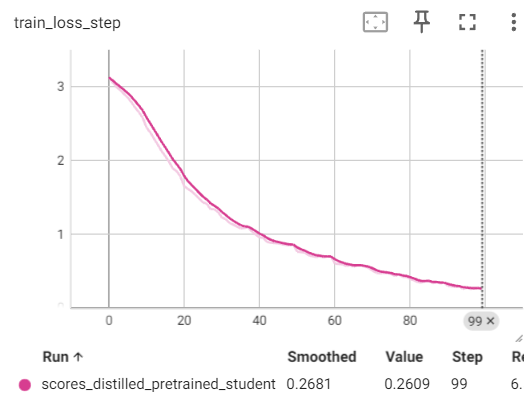

Validation f1 score graph :

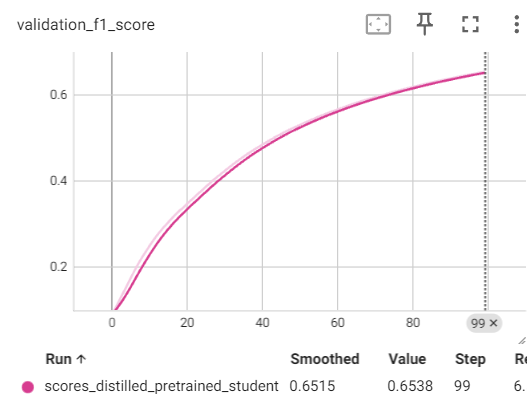

## Test results comparison
 
Teacher model f1 score : 70.22%

Student model f1 score : 65.41%

Distilled pretrained student model f1 score : 65.46%

The scores distillation seems to have slightly improved the results.

## Perform distillation based on scores and feature maps

In [28]:
class ModifiedTeacherResNet50(torch.nn.Module):
    def __init__(self, num_classes : int, pretrained: bool = True) -> None:
        """
        This version of the teacher model returns both the logits AND the feature maps when doing feed forward.
        An implementation of a fine-tunable Resnet50 pretrained (or not) model.
        The final classification layer is replaced with a new one that predicts the number of classes defined by 'num_classes'.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained: A boolean value indicating whether to load the pre-trained weights of the model. Defaults to true.
        """
        super().__init__()
        self.resnet50 = timm.create_model('resnet50', pretrained=pretrained)
        #Replace the final classification layer of the model for fine-tuning purposes.
        self.resnet50.fc = torch.nn.Linear(
            in_features=self.resnet50.fc.in_features,
            out_features=num_classes
        )
        # A placeholder for feature maps.
        self.feature_map = None
        # Register a forward hook to capture feature maps from 'layer4'.
        self.resnet50.layer4.register_forward_hook(self._hook_function)

    def _hook_function(self, module, input, output):
        """A way of getting hold of the feature maps just before the flattening for classification.
        A fine example of modern-day spaghetti engineering. But it works."""
        self.feature_map = output
    
    def forward(self, x):
        logits = self.resnet50(x)
        return logits, self.feature_map

In [29]:
class ModifiedStudentResNet18(torch.nn.Module):
    def __init__(self, num_classes: int, pretrained: bool = True) -> None:
        """
        This version of the student model returns both the logits AND the regressor feature maps when doing feed forward.
        An implementation of a fine-tunable ResNet18 pretrained (or not) model which .
        The final classification layer is replaced with a new one that predicts the number of classes defined by 'num_classes'.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained: A boolean value indicating whether to load the pre-trained weights of the model. Defaults to true.
        """
        super().__init__()
        self.resnet18 = timm.create_model('resnet18', pretrained=pretrained)
        
        # Replace the final classification layer of the model for fine-tuning purposes.
        self.resnet18.fc = torch.nn.Linear(
            in_features=self.resnet18.fc.in_features,
            out_features=num_classes
        )
        
        # Placeholder for feature maps.
        self.feature_map = None
        
        # Add a regressor to align with the teacher's feature maps.
        self.regressor = torch.nn.Sequential(
            torch.nn.Conv2d(512, 2048, kernel_size=1),  # size of resnet18
            torch.nn.ReLU(),
            torch.nn.Conv2d(2048, 2048, kernel_size=3, padding=1),  # to size of resnet50
            torch.nn.ReLU()
        )
        
        # Register a forward hook to capture feature maps from 'layer4'.
        self.resnet18.layer4.register_forward_hook(self._hook_fn)
    
    def _hook_fn(self, module, input, output):
        """A way of getting hold of the feature maps just before the flattening for classification.
        A fine example of modern-day spaghetti engineering. But it works."""
        self.feature_map = output
    
    def forward(self, x):
        logits = self.resnet18(x)
        regressed_features = self.regressor(self.feature_map)
        return logits, regressed_features


In [30]:
class FeatureMapDistilledStudentResnet18(L.LightningModule):
    def __init__(self, num_classes : int,
                 pretrained_student: bool = True,
                 lr : float = 1e-4,
                 temperature : float = 2,
                 feature_map_loss_weight : float = 0.25,
                 cross_entropy_loss_weight : float = 0.75) -> None:
        """A pytorch lightning implementation of the feature map distillation process for the pretrained (or not) Resnet18 model.
        Implementation is inspired from https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html
        The teacher model is the fine-tuned Resnet50.

        Args:
            num_classes: The number of classes to set when replacing the final classification layer for fine-tuning purposes.
            pretrained_student: A boolean value indicating whether to load the pre-trained weights of the student model. Defaults to true.
            lr: The learning rate used during training. Defaults to 1e-4.
            temperature : Controls the smoothness of the output distributions. Larger T leads to smoother distributions, thus smaller probabilities get a larger boost. Defaults to 2.
            feature_map_loss_weight : A weight assigned to the loss calculated on the feature maps. Defaults to 0.25.
            cross_entropy_loss_weight : A weight assigned to the cross entropy loss calculated on the targets. Defaults to 0.75.
        """
        super().__init__()
        # Load the pre-trained (or not) student model.
        self.student_resnet18 = ModifiedStudentResNet18(num_classes=NUM_CLASSES,
                                                        pretrained=pretrained_student)
        # Load the fine-tuned teacher model. Need to remove the resnet50 name from the state_dict for it to match properly.
        checkpoint = torch.load("finetuned_models/pretrained_teacher_training/best.ckpt")
        state_dict = {k.replace("resnet50.", "", 1): v for k, v in checkpoint["state_dict"].items()}
        self.teacherResnet50 = ModifiedTeacherResNet50(num_classes=NUM_CLASSES,
                                                       pretrained=True)
        self.teacherResnet50.load_state_dict(state_dict)
        self.lr = lr
        self.f1_metric = MulticlassF1Score(num_classes=num_classes)
        self.temperature = temperature
        self.feature_map_loss_weight = feature_map_loss_weight
        self.cross_entropy_loss_weight = cross_entropy_loss_weight

    def forward(self, input_tensor: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """This forward method runs the inference for both the teacher and the student model and returns their feature maps and logits as a tuple (teacher_feature_map, student_logits, student_regressor_feature_map)."""
        with torch.no_grad(): #Freeze teacher model weights.
            teacher_logits, teacher_feature_map = self.teacherResnet50(input_tensor)
        
        student_logits, student_regressor_feature_map = self.student_resnet18(input_tensor)
        return teacher_feature_map, student_logits, student_regressor_feature_map

    def training_step(self, batch, batch_idx):
        self.teacherResnet50.eval()
        # training_step defines the train loop.
        input_batch, target_batch = batch
        teacher_feature_map, student_logits, student_regressor_feature_map = self(input_batch)

        hidden_representation_loss = torch.nn.functional.mse_loss(student_regressor_feature_map, teacher_feature_map)

        scores_loss = torch.nn.functional.cross_entropy(student_logits, target_batch)

        loss = self.feature_map_loss_weight * hidden_representation_loss + self.cross_entropy_loss_weight * scores_loss
        
        #Calculate metrics
        self.f1_metric.update(student_logits, target_batch)
        train_f1_score = self.f1_metric.compute()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", train_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        input_batch, target_batch = batch
        _, student_logits, _ = self(input_batch)
        loss = torch.nn.functional.cross_entropy(student_logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(student_logits, target_batch)
        validation_f1_score = self.f1_metric.compute()
        self.log("validation_loss", loss, on_epoch=True, prog_bar=True)
        self.log("validation_f1_score", validation_f1_score, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        input_batch, target_batch = batch
        _, student_logits, _= self(input_batch)
        loss = torch.nn.functional.cross_entropy(student_logits, target_batch)
        #Calculate metrics
        self.f1_metric.update(student_logits, target_batch)
        test_f1_score = self.f1_metric.compute()
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_f1_score", test_f1_score, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [21]:
# Instantiate the feature map distillation model.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer of the student model.
feature_map_distilled_student_resnet18 = FeatureMapDistilledStudentResnet18(num_classes=NUM_CLASSES,
                                                                            pretrained_student=True,
                                                                            lr=LEARNINIG_RATE,
                                                                            temperature=2,
                                                                            feature_map_loss_weight=0.5,
                                                                            cross_entropy_loss_weight=0.5)

C:\Users\Yanis\AppData\Local\Temp\ipykernel_25968\308962744.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("finetuned_models/pretrained_teacher

In [22]:
# Only save to disk the best performing version of the student model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/feature_map_distilled_pretrained_student_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [23]:
trainer.fit(model=feature_map_distilled_student_resnet18, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\paris_cite\m2\cours\aide décision\knowledge_distillation\models\feature_map_distilled_pretrained_student_training exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | student_resnet18 | ModifiedStudentResNet18 | 50.0 M | train
1 | teacherResnet50  | ModifiedTeacherResNet50 | 23.5 M | train
---------------------------------------------------------------------
73.5 M    Trainable params
0         Non-trainable params
73.5 M    Total params
294.046   Total estimated model params size (MB)
318       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:35<00:00,  0.29it/s, v_num=6, train_loss_step=1.150, train_f1_score_step=0.224, validation_loss=1.850, validation_f1_score=0.232, train_loss_epoch=1.280, train_f1_score_epoch=0.149]

Epoch 0, global step 10: 'validation_f1_score' reached 0.23181 (best 0.23181), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:59<00:00,  0.17it/s, v_num=6, train_loss_step=0.855, train_f1_score_step=0.341, validation_loss=1.480, validation_f1_score=0.345, train_loss_epoch=0.985, train_f1_score_epoch=0.294]

Epoch 1, global step 20: 'validation_f1_score' reached 0.34548 (best 0.34548), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:59<00:00,  0.17it/s, v_num=6, train_loss_step=0.656, train_f1_score_step=0.420, validation_loss=1.160, validation_f1_score=0.423, train_loss_epoch=0.733, train_f1_score_epoch=0.386]

Epoch 2, global step 30: 'validation_f1_score' reached 0.42294 (best 0.42294), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:54<00:00,  0.18it/s, v_num=6, train_loss_step=0.555, train_f1_score_step=0.481, validation_loss=0.960, validation_f1_score=0.483, train_loss_epoch=0.584, train_f1_score_epoch=0.454]

Epoch 3, global step 40: 'validation_f1_score' reached 0.48330 (best 0.48330), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=6, train_loss_step=0.471, train_f1_score_step=0.528, validation_loss=0.865, validation_f1_score=0.529, train_loss_epoch=0.487, train_f1_score_epoch=0.508]

Epoch 4, global step 50: 'validation_f1_score' reached 0.52943 (best 0.52943), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:38<00:00,  0.26it/s, v_num=6, train_loss_step=0.398, train_f1_score_step=0.564, validation_loss=0.810, validation_f1_score=0.565, train_loss_epoch=0.414, train_f1_score_epoch=0.548]

Epoch 5, global step 60: 'validation_f1_score' reached 0.56493 (best 0.56493), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:37<00:00,  0.26it/s, v_num=6, train_loss_step=0.341, train_f1_score_step=0.593, validation_loss=0.787, validation_f1_score=0.594, train_loss_epoch=0.355, train_f1_score_epoch=0.580]

Epoch 6, global step 70: 'validation_f1_score' reached 0.59362 (best 0.59362), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:42<00:00,  0.23it/s, v_num=6, train_loss_step=0.297, train_f1_score_step=0.617, validation_loss=0.810, validation_f1_score=0.617, train_loss_epoch=0.303, train_f1_score_epoch=0.606]

Epoch 7, global step 80: 'validation_f1_score' reached 0.61735 (best 0.61735), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:51<00:00,  0.19it/s, v_num=6, train_loss_step=0.249, train_f1_score_step=0.637, validation_loss=0.817, validation_f1_score=0.637, train_loss_epoch=0.260, train_f1_score_epoch=0.628]

Epoch 8, global step 90: 'validation_f1_score' reached 0.63717 (best 0.63717), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=6, train_loss_step=0.211, train_f1_score_step=0.654, validation_loss=0.854, validation_f1_score=0.654, train_loss_epoch=0.222, train_f1_score_epoch=0.646]

Epoch 9, global step 100: 'validation_f1_score' reached 0.65421 (best 0.65421), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_pretrained_student_training\\best-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:36<00:00,  0.27it/s, v_num=6, train_loss_step=0.211, train_f1_score_step=0.654, validation_loss=0.854, validation_f1_score=0.654, train_loss_epoch=0.222, train_f1_score_epoch=0.646]


In [24]:
trainer.test(model=feature_map_distilled_student_resnet18, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score         0.6549111604690552
        test_loss           0.8590928912162781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8590928912162781, 'test_f1_score': 0.6549111604690552}]

Training loss graph :

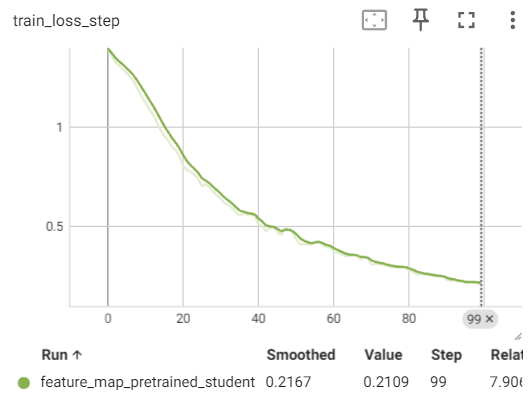

Validation f1 score graph :

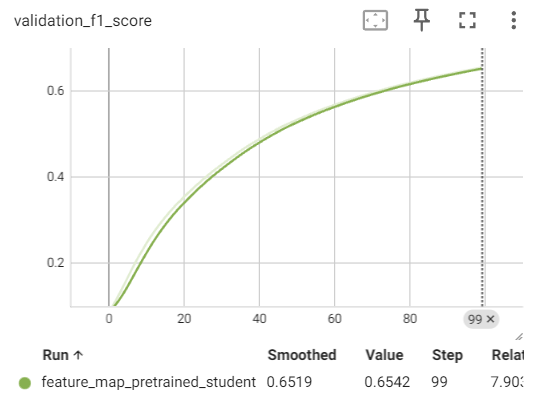

## Test results comparison
 
Teacher model f1 score : 70.22%

Student model f1 score : 65.41%

Distilled pretrained student model f1 score : 65.46%

Feature map distilled student model f1 score : 65.49%

Results are slightly worse.

# Strategy 2 : Knowledge distillation using a non pre-trained student

## Train the non pre-trained student network on CIFAR 10

In [52]:
# Instantiate the pre-trained student model with 10 classes for the classifier.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer.
studentResnet18 = TrainingStudentResNet18(num_classes=10,
                                          pretrained=False, # Do not load the weights learned from pre-training on ImageNet.
                                          lr=LEARNINIG_RATE)

In [53]:
# Only save to disk the best performing version of the model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/non_pretrained_student_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [54]:
trainer.fit(model=studentResnet18, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | resnet18 | StudentResNet18 | 11.2 M | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
95        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:20<00:00,  0.48it/s, v_num=0, train_loss_step=2.030, train_f1_score_step=0.155, validation_loss=2.230, validation_f1_score=0.154, train_loss_epoch=2.140, train_f1_score_epoch=0.150]

Epoch 0, global step 10: 'validation_f1_score' reached 0.15416 (best 0.15416), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:19<00:00,  0.50it/s, v_num=0, train_loss_step=1.820, train_f1_score_step=0.178, validation_loss=2.230, validation_f1_score=0.178, train_loss_epoch=1.920, train_f1_score_epoch=0.166]

Epoch 1, global step 20: 'validation_f1_score' reached 0.17791 (best 0.17791), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:19<00:00,  0.51it/s, v_num=0, train_loss_step=1.500, train_f1_score_step=0.211, validation_loss=1.980, validation_f1_score=0.212, train_loss_epoch=1.620, train_f1_score_epoch=0.195]

Epoch 2, global step 30: 'validation_f1_score' reached 0.21246 (best 0.21246), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:20<00:00,  0.48it/s, v_num=0, train_loss_step=1.280, train_f1_score_step=0.257, validation_loss=1.530, validation_f1_score=0.259, train_loss_epoch=1.350, train_f1_score_epoch=0.235]

Epoch 3, global step 40: 'validation_f1_score' reached 0.25903 (best 0.25903), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:21<00:00,  0.47it/s, v_num=0, train_loss_step=1.140, train_f1_score_step=0.306, validation_loss=1.310, validation_f1_score=0.308, train_loss_epoch=1.180, train_f1_score_epoch=0.284]

Epoch 4, global step 50: 'validation_f1_score' reached 0.30827 (best 0.30827), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:20<00:00,  0.48it/s, v_num=0, train_loss_step=1.010, train_f1_score_step=0.350, validation_loss=1.190, validation_f1_score=0.352, train_loss_epoch=1.040, train_f1_score_epoch=0.331]

Epoch 5, global step 60: 'validation_f1_score' reached 0.35219 (best 0.35219), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:20<00:00,  0.50it/s, v_num=0, train_loss_step=0.908, train_f1_score_step=0.388, validation_loss=1.130, validation_f1_score=0.389, train_loss_epoch=0.917, train_f1_score_epoch=0.371]

Epoch 6, global step 70: 'validation_f1_score' reached 0.38925 (best 0.38925), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:20<00:00,  0.50it/s, v_num=0, train_loss_step=0.796, train_f1_score_step=0.420, validation_loss=1.080, validation_f1_score=0.421, train_loss_epoch=0.795, train_f1_score_epoch=0.406]

Epoch 7, global step 80: 'validation_f1_score' reached 0.42085 (best 0.42085), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:20<00:00,  0.50it/s, v_num=0, train_loss_step=0.704, train_f1_score_step=0.447, validation_loss=1.110, validation_f1_score=0.448, train_loss_epoch=0.679, train_f1_score_epoch=0.435]

Epoch 8, global step 90: 'validation_f1_score' reached 0.44765 (best 0.44765), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:20<00:00,  0.49it/s, v_num=0, train_loss_step=0.559, train_f1_score_step=0.469, validation_loss=1.120, validation_f1_score=0.470, train_loss_epoch=0.580, train_f1_score_epoch=0.459]

Epoch 9, global step 100: 'validation_f1_score' reached 0.47025 (best 0.47025), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\non_pretrained_student_training\\best.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:20<00:00,  0.48it/s, v_num=0, train_loss_step=0.559, train_f1_score_step=0.469, validation_loss=1.120, validation_f1_score=0.470, train_loss_epoch=0.580, train_f1_score_epoch=0.459]


In [55]:
# Test the student model.
trainer.test(model=studentResnet18, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score          0.47136390209198
        test_loss           1.1162725687026978
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1162725687026978, 'test_f1_score': 0.47136390209198}]

Train loss graph :

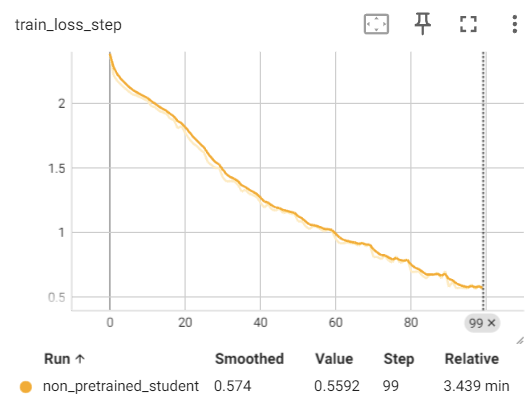


Validation f1 score graph :

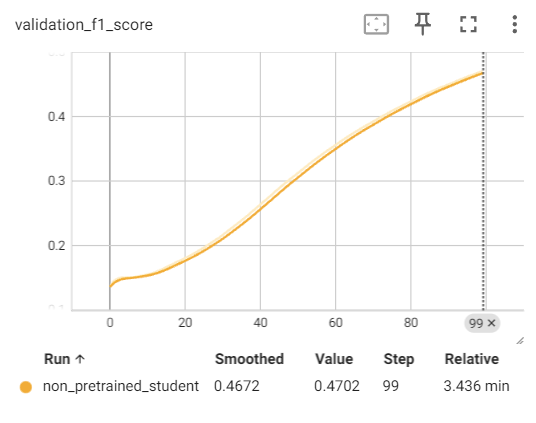

## Training results comparison
 
Teacher model f1 score : 70.22%

Non pre-trained student model f1 score : 47.13%

# Perform distilation based on scores

In [56]:
# Instantiate the distillation model.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer of the student model.
distilled_student_resnet18 = DistilledStudentResnet18(num_classes=NUM_CLASSES,
                                                      pretrained_student=False,
                                                      lr=LEARNINIG_RATE,
                                                      temperature=2,
                                                      soft_target_loss_weight=0.1,
                                                      cross_entropy_loss_weight=1.0)

In [57]:
# Only save to disk the best performing version of the student model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/distilled_non_pretrained_student_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [58]:
trainer.fit(model=distilled_student_resnet18, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params | Mode 
-------------------------------------------------------------
0 | student_resnet18 | StudentResNet18 | 11.2 M | train
1 | teacherResnet50  | TeacherResNet50 | 23.5 M | train
-------------------------------------------------------------
34.7 M    Trainable params
0         Non-trainable params
34.7 M    Total params
138.841   Total estimated model params size (MB)
313       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=0, train_loss_step=2.700, train_f1_score_step=0.154, validation_loss=2.230, validation_f1_score=0.153, train_loss_epoch=2.820, train_f1_score_epoch=0.149]

Epoch 0, global step 10: 'validation_f1_score' reached 0.15293 (best 0.15293), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=0, train_loss_step=2.400, train_f1_score_step=0.176, validation_loss=2.230, validation_f1_score=0.177, train_loss_epoch=2.540, train_f1_score_epoch=0.165]

Epoch 1, global step 20: 'validation_f1_score' reached 0.17681 (best 0.17681), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=0, train_loss_step=1.950, train_f1_score_step=0.213, validation_loss=1.940, validation_f1_score=0.214, train_loss_epoch=2.150, train_f1_score_epoch=0.196]

Epoch 2, global step 30: 'validation_f1_score' reached 0.21436 (best 0.21436), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=0, train_loss_step=1.670, train_f1_score_step=0.261, validation_loss=1.560, validation_f1_score=0.263, train_loss_epoch=1.800, train_f1_score_epoch=0.238]

Epoch 3, global step 40: 'validation_f1_score' reached 0.26288 (best 0.26288), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:36<00:00,  0.27it/s, v_num=0, train_loss_step=1.520, train_f1_score_step=0.311, validation_loss=1.310, validation_f1_score=0.313, train_loss_epoch=1.570, train_f1_score_epoch=0.288]

Epoch 4, global step 50: 'validation_f1_score' reached 0.31268 (best 0.31268), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:36<00:00,  0.27it/s, v_num=0, train_loss_step=1.310, train_f1_score_step=0.354, validation_loss=1.230, validation_f1_score=0.356, train_loss_epoch=1.380, train_f1_score_epoch=0.335]

Epoch 5, global step 60: 'validation_f1_score' reached 0.35574 (best 0.35574), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=0, train_loss_step=1.130, train_f1_score_step=0.390, validation_loss=1.200, validation_f1_score=0.392, train_loss_epoch=1.210, train_f1_score_epoch=0.374]

Epoch 6, global step 70: 'validation_f1_score' reached 0.39163 (best 0.39163), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=0, train_loss_step=1.050, train_f1_score_step=0.421, validation_loss=1.130, validation_f1_score=0.422, train_loss_epoch=1.060, train_f1_score_epoch=0.407]

Epoch 7, global step 80: 'validation_f1_score' reached 0.42208 (best 0.42208), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=0, train_loss_step=0.861, train_f1_score_step=0.447, validation_loss=1.140, validation_f1_score=0.448, train_loss_epoch=0.902, train_f1_score_epoch=0.436]

Epoch 8, global step 90: 'validation_f1_score' reached 0.44829 (best 0.44829), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:37<00:00,  0.27it/s, v_num=0, train_loss_step=0.747, train_f1_score_step=0.471, validation_loss=1.160, validation_f1_score=0.471, train_loss_epoch=0.753, train_f1_score_epoch=0.460]

Epoch 9, global step 100: 'validation_f1_score' reached 0.47142 (best 0.47142), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\distilled_non_pretrained_student_training\\best.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:39<00:00,  0.26it/s, v_num=0, train_loss_step=0.747, train_f1_score_step=0.471, validation_loss=1.160, validation_f1_score=0.471, train_loss_epoch=0.753, train_f1_score_epoch=0.460]


In [59]:
trainer.test(model=distilled_student_resnet18, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:03<00:00,  0.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score         0.47255751490592957
        test_loss           1.1684184074401855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1684184074401855, 'test_f1_score': 0.47255751490592957}]

Training loss graph :

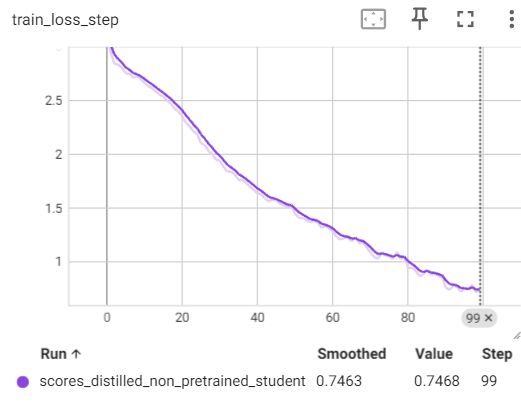

Validation f1 score graph :

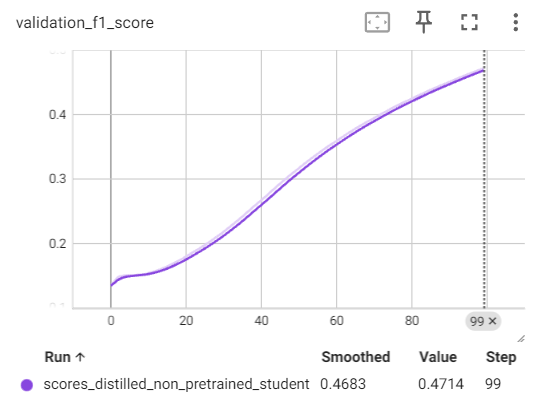

## Training results comparison
 
Teacher model f1 score : 70.22%

Non pre-trained student model f1 score : 47.13%

Distilled non pre-trained student model f1 score : 47.25%

The distillation process gave us slightly improved results.

# Perform distillation based on scores and feature maps

In [31]:
# Instantiate the feature map distillation model.
torch.manual_seed(MANUAL_SEED) # Seed the weights for the new classification layer of the student model.
feature_map_distilled_student_resnet18 = FeatureMapDistilledStudentResnet18(num_classes=NUM_CLASSES,
                                                                            pretrained_student=False, # Student is not pre-trained
                                                                            lr=LEARNINIG_RATE,
                                                                            temperature=2,
                                                                            feature_map_loss_weight=0.8,
                                                                            cross_entropy_loss_weight=0.2)

C:\Users\Yanis\AppData\Local\Temp\ipykernel_27504\3171930936.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("finetuned_models/pretrained_teache

In [32]:
# Only save to disk the best performing version of the student model throughout training (best f1 score).
checkpoint_callback = ModelCheckpoint(
        dirpath="models/feature_map_distilled_non_pretrained_student_training",
        monitor="validation_f1_score",
        filename="best",
        mode="max",
        save_last=False,
        verbose=True
    )

trainer = L.Trainer(max_epochs=EPOCHS,
                    log_every_n_steps=1,
                    val_check_interval=1,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [33]:
trainer.fit(model=feature_map_distilled_student_resnet18, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | student_resnet18 | ModifiedStudentResNet18 | 50.0 M | train
1 | teacherResnet50  | ModifiedTeacherResNet50 | 23.5 M | train
---------------------------------------------------------------------
73.5 M    Trainable params
0         Non-trainable params
73.5 M    Total params
294.046   Total estimated model params size (MB)
318       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=5, train_loss_step=0.706, train_f1_score_step=0.156, validation_loss=2.240, validation_f1_score=0.155, train_loss_epoch=0.737, train_f1_score_epoch=0.152]

Epoch 0, global step 10: 'validation_f1_score' reached 0.15488 (best 0.15488), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=5, train_loss_step=0.649, train_f1_score_step=0.176, validation_loss=2.230, validation_f1_score=0.176, train_loss_epoch=0.679, train_f1_score_epoch=0.165]

Epoch 1, global step 20: 'validation_f1_score' reached 0.17649 (best 0.17649), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=5, train_loss_step=0.582, train_f1_score_step=0.210, validation_loss=2.030, validation_f1_score=0.211, train_loss_epoch=0.612, train_f1_score_epoch=0.194]

Epoch 2, global step 30: 'validation_f1_score' reached 0.21124 (best 0.21124), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:34<00:00,  0.29it/s, v_num=5, train_loss_step=0.530, train_f1_score_step=0.256, validation_loss=1.560, validation_f1_score=0.258, train_loss_epoch=0.552, train_f1_score_epoch=0.234]

Epoch 3, global step 40: 'validation_f1_score' reached 0.25799 (best 0.25799), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=5, train_loss_step=0.492, train_f1_score_step=0.305, validation_loss=1.320, validation_f1_score=0.307, train_loss_epoch=0.507, train_f1_score_epoch=0.283]

Epoch 4, global step 50: 'validation_f1_score' reached 0.30736 (best 0.30736), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=5, train_loss_step=0.462, train_f1_score_step=0.349, validation_loss=1.180, validation_f1_score=0.351, train_loss_epoch=0.471, train_f1_score_epoch=0.330]

Epoch 5, global step 60: 'validation_f1_score' reached 0.35073 (best 0.35073), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=5, train_loss_step=0.431, train_f1_score_step=0.386, validation_loss=1.140, validation_f1_score=0.388, train_loss_epoch=0.441, train_f1_score_epoch=0.370]

Epoch 6, global step 70: 'validation_f1_score' reached 0.38768 (best 0.38768), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:36<00:00,  0.27it/s, v_num=5, train_loss_step=0.414, train_f1_score_step=0.418, validation_loss=1.120, validation_f1_score=0.419, train_loss_epoch=0.413, train_f1_score_epoch=0.404]

Epoch 7, global step 80: 'validation_f1_score' reached 0.41901 (best 0.41901), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:35<00:00,  0.28it/s, v_num=5, train_loss_step=0.383, train_f1_score_step=0.445, validation_loss=1.090, validation_f1_score=0.446, train_loss_epoch=0.385, train_f1_score_epoch=0.433]

Epoch 8, global step 90: 'validation_f1_score' reached 0.44572 (best 0.44572), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:36<00:00,  0.28it/s, v_num=5, train_loss_step=0.349, train_f1_score_step=0.469, validation_loss=1.070, validation_f1_score=0.469, train_loss_epoch=0.357, train_f1_score_epoch=0.458]

Epoch 9, global step 100: 'validation_f1_score' reached 0.46943 (best 0.46943), saving model to 'C:\\paris_cite\\m2\\cours\\aide décision\\knowledge_distillation\\models\\feature_map_distilled_non_pretrained_student_training\\best.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:39<00:00,  0.25it/s, v_num=5, train_loss_step=0.349, train_f1_score_step=0.469, validation_loss=1.070, validation_f1_score=0.469, train_loss_epoch=0.357, train_f1_score_epoch=0.458]


In [34]:
trainer.test(model=feature_map_distilled_student_resnet18, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\paris_cite\m2\cours\aide décision\knowledge_distillation\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_score         0.47061362862586975
        test_loss           1.0669974088668823
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0669974088668823, 'test_f1_score': 0.47061362862586975}]

Training loss graph :

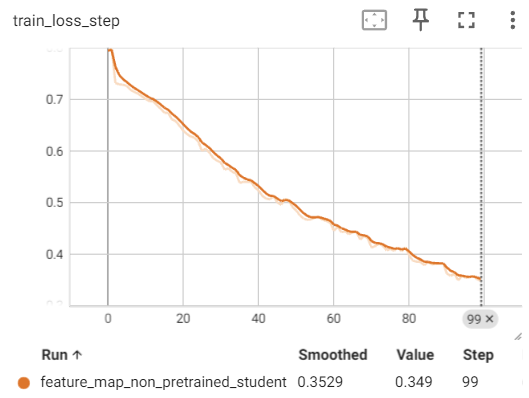

Validation f1 score graph :"

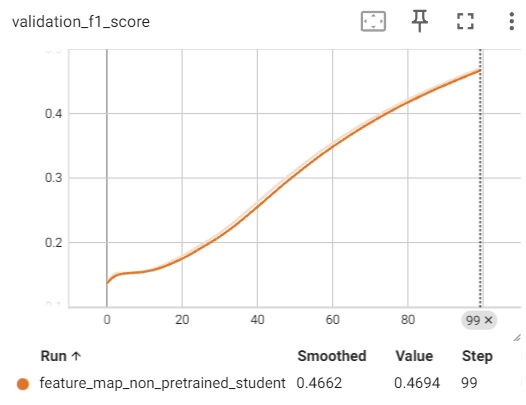

## Training results comparison
 
Teacher model f1 score : 70.22%

Non pre-trained student model f1 score : 47.13%

Distilled non pre-trained student model f1 score : 47.25%

Feature-map distilled non pre-trained student model f1 score : 47.06%

The distillation process gave us slightly improved results.

# Validation f1 score comparison graphs

Pre-trained vs non pre-trained student :

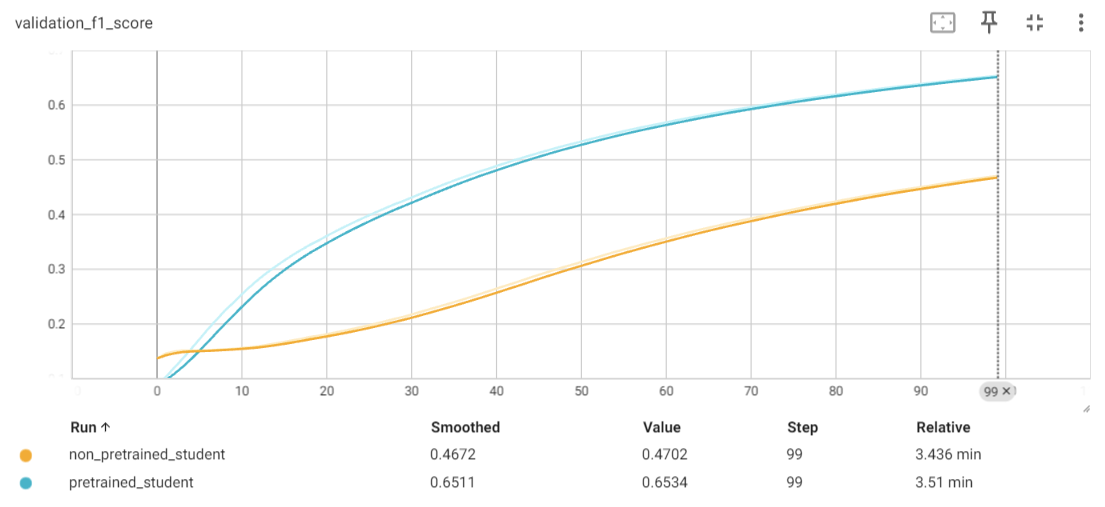


Pre-trained vs non pre-trained scores distillation student :

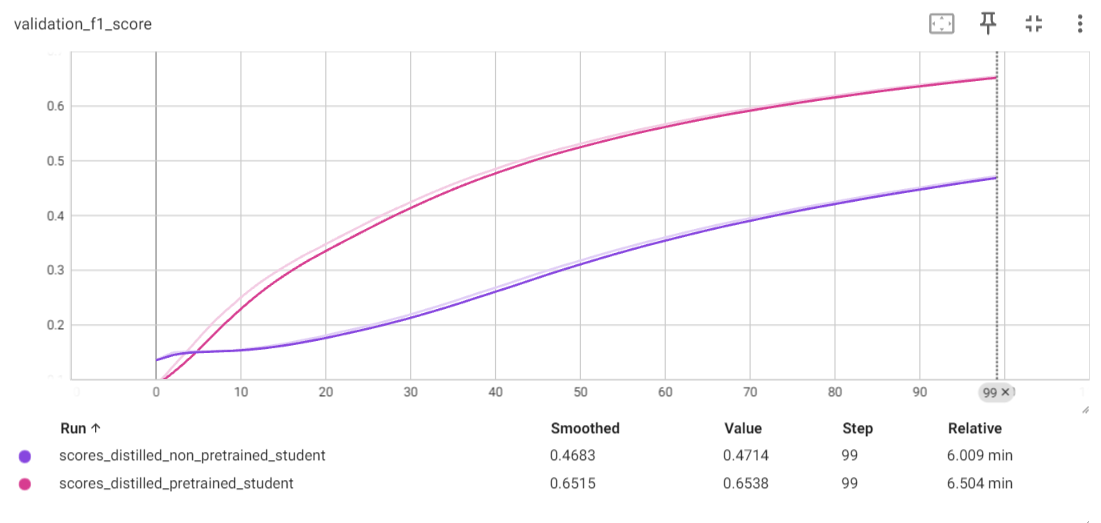


Pre-trained vs non pre-trained feature map + scores distillation student :

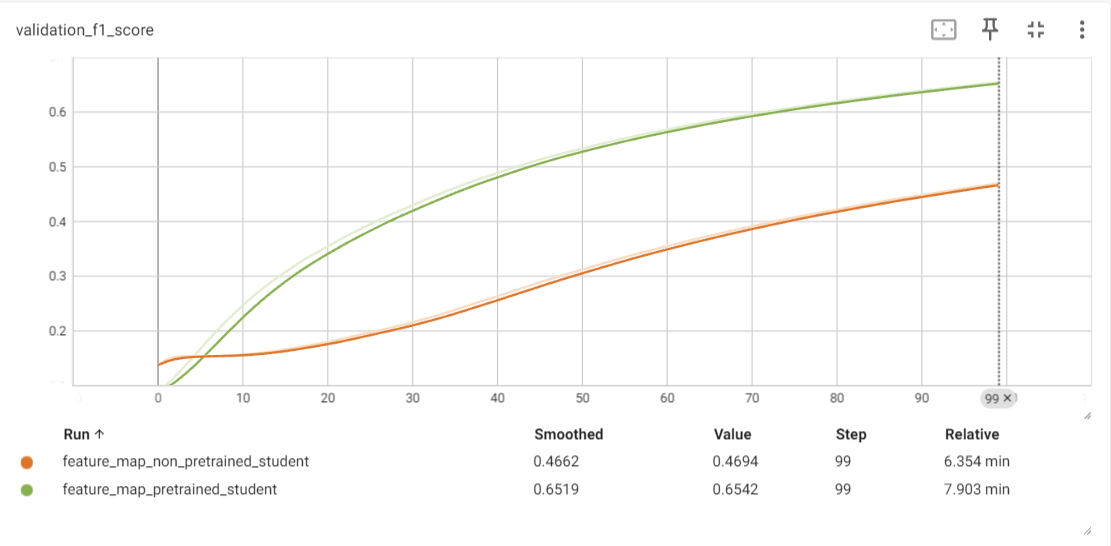
